In [1]:
import os
import numpy as np
from pathlib import Path
from scipy.stats import pointbiserialr
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    roc_curve, 
)
from side_info_decoding.bmm_hmm import BMM_HMM, posterior_inference
from side_info_decoding.viz import plot_bmm_hmm_results
seed = 666

In [2]:
brain_region = "dg"

dir_path = Path("/home/yizi/density_decoding/saved_results")

pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    "0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a",
    "143dd7cf-6a47-47a1-906d-927ad7fe9117",
    "16799c7a-e395-435d-a4c4-a678007e1550",
    "1e176f17-d00f-49bb-87ff-26d237b525f1",
    "27bac116-ea57-4512-ad35-714a62d259cd",
    "31f3e083-a324-4b88-b0a4-7788ec37b191",
    "6fc4d73c-2071-43ec-a756-c6c6d8322c8b",
    "7d999a68-0215-4e45-8e6c-879c6ca2b771",
    "8b7c808f-763b-44c8-b273-63c6afbc6aae",
    "9117969a-3f0d-478b-ad75-98263e3bfacf",
    "ad714133-1e03-4d3a-8427-33fc483daf1a"
]

ys, ds = [], []
for _, pid in enumerate(pids):

    y, d, trial_idx = [], [], []
    for i in range(5):
        y.append(
            np.load(
                dir_path/pid/"choice"/"all"/"y_obs"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["density_based"]
        )
        d.append(
            np.load(
                dir_path/pid/"choice"/brain_region/"y_prob"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["density_based"]
        )
        trial_idx.append(
            np.load(
                dir_path/pid/"choice"/"all"/"trial_idx"/f"fold_{i+1}.npy", allow_pickle=True
            )
        )
    trial_idx = np.concatenate(trial_idx)
    y = np.concatenate(y)[np.argsort(trial_idx)]
    d = np.concatenate(d)[np.argsort(trial_idx),1]
    ys.append(y.reshape(-1,1))
    ds.append(d.reshape(-1,1))
ys = np.array(ys)
ds = np.array(ds)

/tmp/ipykernel_59492/3632050337.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys = np.array(ys)
/tmp/ipykernel_59492/3632050337.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ds = np.array(ds)


In [3]:
pid = pids[-1]
print(pid)
print(brain_region)
d = ds[-1].squeeze()
y = ys[-1].squeeze()

save_path, save_metrics = {}, {}
out_path = Path("/home/yizi/side_info_decoding/saved_results")
for res in ["vanilla_bmm_hmm_metrics", "vanilla_bmm_hmm_figures"]:
    save_path.update({res: out_path/res/pid})
    os.makedirs(save_path[res], exist_ok=True)

ad714133-1e03-4d3a-8427-33fc483daf1a
dg


In [4]:
# initialize bmm-hmm

states = [0, 1, 2]
init_pi = {0: np.log(0.2), 1:np.log(0.4), 2: np.log(0.4)}
init_a = {
        0: {0: np.log(.9), 1: np.log(.05), 2: np.log(.05)},
        1: {0: np.log(.05), 1: np.log(.9), 2: np.log(.05)},
        2: {0: np.log(.05), 1: np.log(.05), 2: np.log(.9)} }
init_phi = {
        0: {0: np.log(.6), 1: np.log(.4)},
        1: {0: np.log(.9), 1: np.log(.1)},
        2: {0: np.log(.1), 1: np.log(.9)}
         }
init_beta_a = [3, 1]
init_beta_b = [1, 3]

In [5]:
# fit bmm-hmm

bmm_hmm = BMM_HMM(d, init_pi, init_a, init_phi, init_beta_a, init_beta_b, tol=1e-1)
bmm_hmm.update(d)

BMM Convergence Achieved: True
log-likelihood: 328.2963597167414
BMM Convergence Achieved: True
log-likelihood: 329.6295557460869
BMM Convergence Achieved: True
log-likelihood: 330.0035703259037
BMM Convergence Achieved: True
log-likelihood: 330.1836455296697
BMM Convergence Achieved: True
log-likelihood: 330.28944461489067
BMM Convergence Achieved: True
log-likelihood: 330.37266541322714


In [6]:
a_hat = bmm_hmm.a
phi_hat = bmm_hmm.phi
beta_a_hat = bmm_hmm.beta_a
beta_b_hat = bmm_hmm.beta_b

In [7]:
# inference

A = np.exp(
    [[a_hat[0][0], a_hat[0][1], a_hat[0][2]], 
     [a_hat[1][0], a_hat[1][1], a_hat[1][2]],
     [a_hat[2][0], a_hat[2][1], a_hat[2][2]]]
)

B = np.exp(
    [[phi_hat[0][0], phi_hat[0][1]], 
     [phi_hat[1][0], phi_hat[1][1]],
     [phi_hat[2][0], phi_hat[2][1]]]
)

states = np.array([np.array(list(state.values())) for state in bmm_hmm.forward(d)])
states = np.exp(states)
states = states / states.sum(1)[:,None]
states[np.isnan(states)] = np.tile(np.nanmean(states, 0), int(len(states[np.isnan(states)])/states.shape[1]))
post_preds, post_probs = posterior_inference(bmm_hmm, d)

save_metrics.update({
    "acc": {
        "baseline": accuracy_score(y, [1 if d_k > .5 else 0 for d_k in d]),
        "bmmhmm": accuracy_score(y, post_preds)
    }
})
save_metrics.update({
    "auc": {
        "baseline": roc_auc_score(y, d),
        "bmmhmm": roc_auc_score(y, post_probs)
    }
})
save_metrics.update({
    "corr": {
      "baseline": pointbiserialr(y, d)[0],
      "bmmhmm": pointbiserialr(y, post_probs)[0]
    },
})
np.save(save_path["vanilla_bmm_hmm_metrics"] / f"{brain_region}.npy", save_metrics)

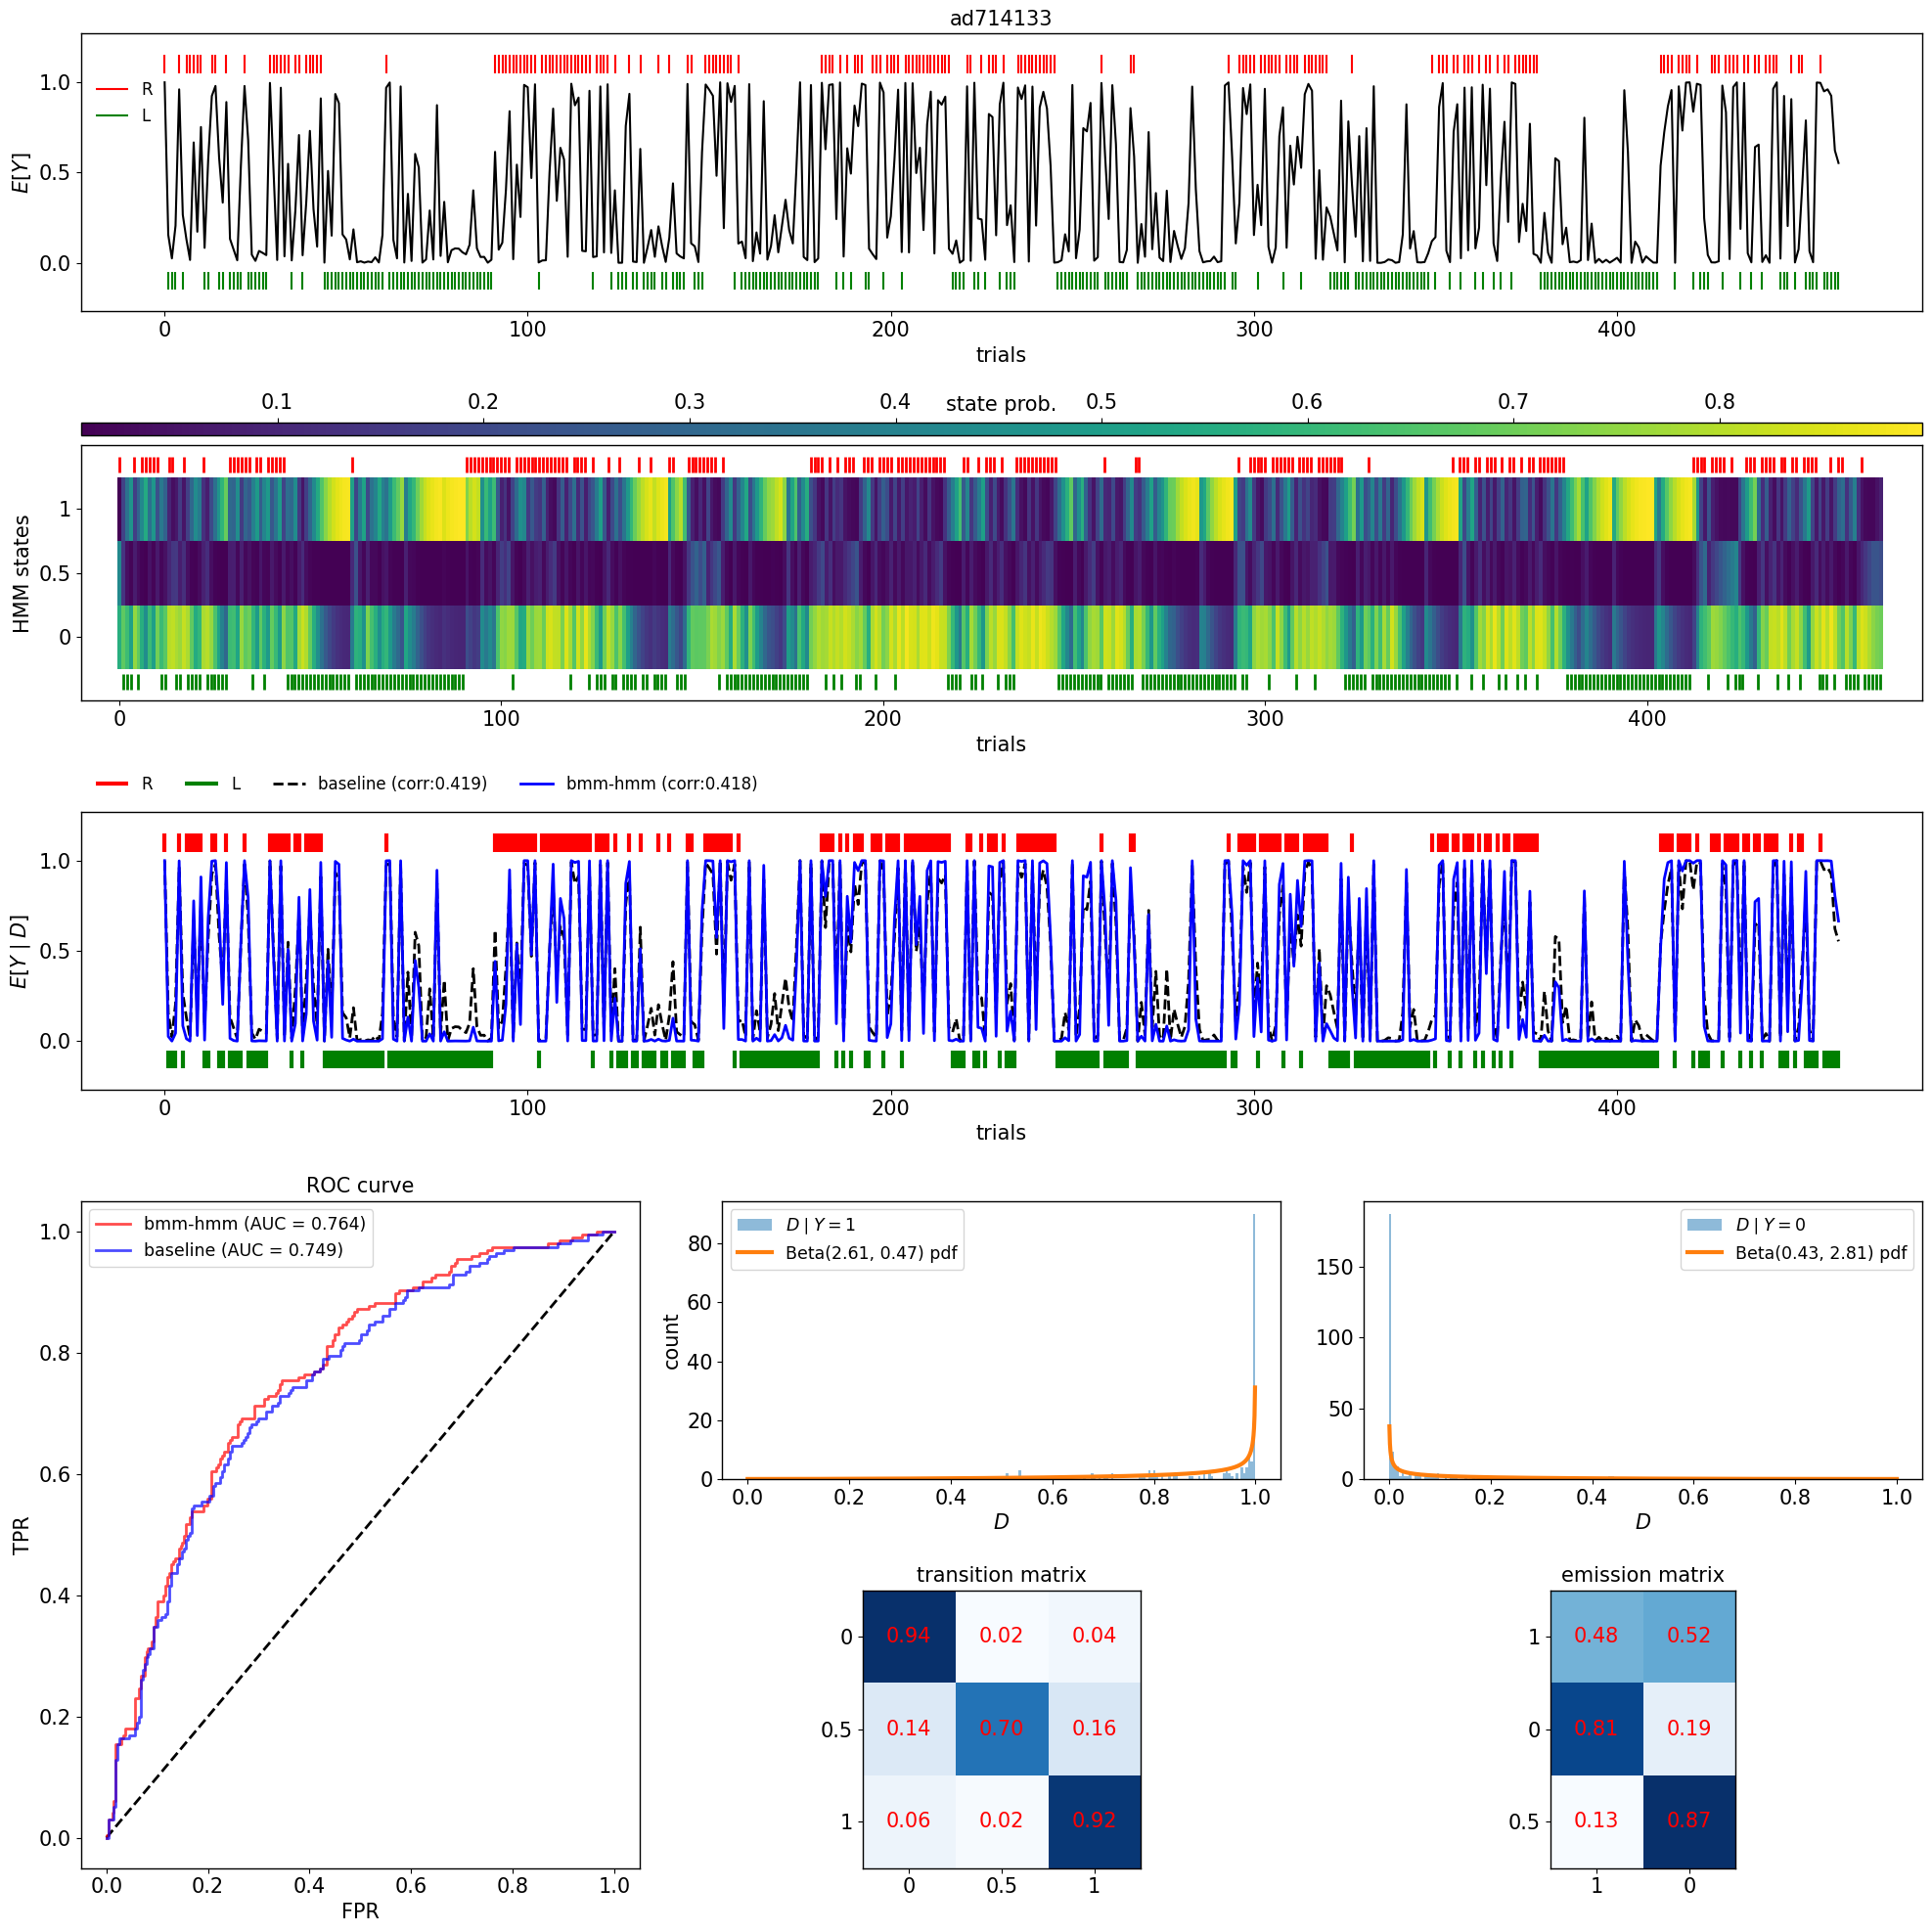

In [8]:
plot_bmm_hmm_results(
    estimates=d,
    post_preds=post_preds,
    post_probs=post_probs,
    states=states,
    choices=y,
    params=(A, B, beta_a_hat, beta_b_hat),
    save_metrics=save_metrics,
    pid=pid,
    brain_region=brain_region
)